# FSTURB: forcing amplitude sensitivity

In [1]:
import itertools

import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import crocosi.postp as pp
import crocosi.plot as cplt

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(jobs=4)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:60026 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


---

## compare energy time series

In [4]:
#root_path = '/home/c11-data/Test_aponte/fsturb/'
root_path = '/home/datawork-lops-osi/equinox/itbalt/'

M = [0,1]
A = [0,1,2,3]

runs = {m: ['fsturb_m{}_a{}_4km_0a600j'.format(m,a) for a in A] 
        for m in M}

R = {m: [pp.Run(root_path+run, outputs=['surf', 'his'], 
           grid_periodicity=True,
           ) for run in runs[m]
        ] for m in M}

for m in R:
    for r in R[m]:
        r['surf'] = (r['surf']
                     .assign_coords(time=r['surf']
                                    .time_instant.chunk({'time':None}))
                    )
        r['his'] = (r['his']
                    .assign_coords(time=r['his']
                                   .time_counter.chunk({'time':None}))
                   )

forcing = [r['fst_F'] for r in R[0]]

colors = {M[0]: cplt.get_cmap_colors(len(A)),
          M[1]: cplt.get_cmap_colors(len(A), cmap='viridis')
         }

Text(0.5, 1.0, 'kinetic energy')

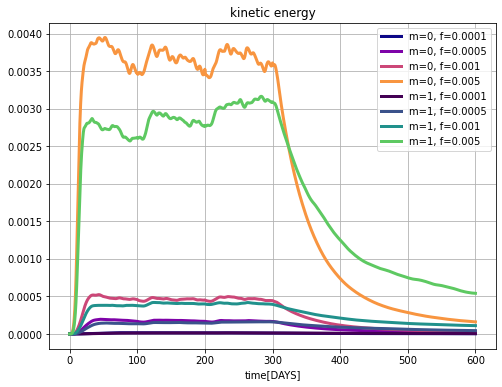

In [6]:

fig, ax = plt.subplots(1, 1, figsize=(8,6))
linestyles = ['-','-']
for m, ls in zip(R.keys(), linestyles):
    _R = R[m]
    for r, f, c in zip(_R, forcing, colors[m]):
        r.stats['KINETIC_ENRG'].plot(ax=ax, label='m={}, f={}'.format(m, f), 
                                     color=c, ls=ls, lw=3)
ax.legend()
ax.grid()
ax.set_title('kinetic energy')

---

## snapshots at day 200

In [7]:
t = 200.
ds = xr.concat([xr.concat([r['surf'].sel(time=t) for r in _R],
                         dim=pd.Series(forcing).rename('forcing'))
                for m, _R in R.items()],
               dim=pd.Series(M).rename('mode')
              ).persist()

In [8]:
# add relative vorticity
r = R[0][0]

u, v = ds['u'], ds['v']
ds['zeta'] = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

f_rho = r['grid'].f + r['grid'].x_rho*0.
f_zeta = r.xgrid.interp(r.xgrid.interp(f_rho, 'eta'), 'xi')
ds = ds.assign_coords(f_zeta=f_zeta)

ds['zeta_over_f'] = ds.zeta/ds.f_zeta

In [9]:
# to be updated
def plot_Fy(p, ax=None, scale=1, ls='--', color='k', **kwargs):
    #p = r.params_output
    ymid = p['fst_ymid']*scale
    ywid = p['fst_ywid']*scale
    if ax is not None:
        ax.axhline(ymid-ywid, ls=ls, color=color)
        ax.axhline(ymid+ywid, ls=ls, color=color)
    else:
        plt.axhline(ymid+ywid, ls=ls, color=color)
        plt.axhline(ymid-ywid, ls=ls, color=color)

### mode 0

In [10]:
V = ['ssh', 'T', 'u', 'v', 'zeta_over_f']

vlims = {'ssh': {}, 'T': {'cmap': 'inferno_r'}, 
         'u': {'vmin':-.3,'vmax':.3, 'cmap': 'RdBu_r'}, 
         'v': {'vmin':-.3,'vmax':.3, 'cmap': 'RdBu_r'}, 
         'zeta_over_f': {'vmin':-.3,'vmax':.3, 'cmap': 'RdBu_r'}}

hmap_kwargs = {'col': 'forcing', 'col_wrap': len(forcing),
               'subplot_kws': {'aspect':'equal'},
               'aspect':.5, 'figsize':(15,5),
               'ylim': [500*1e3, 2500*1e3]}

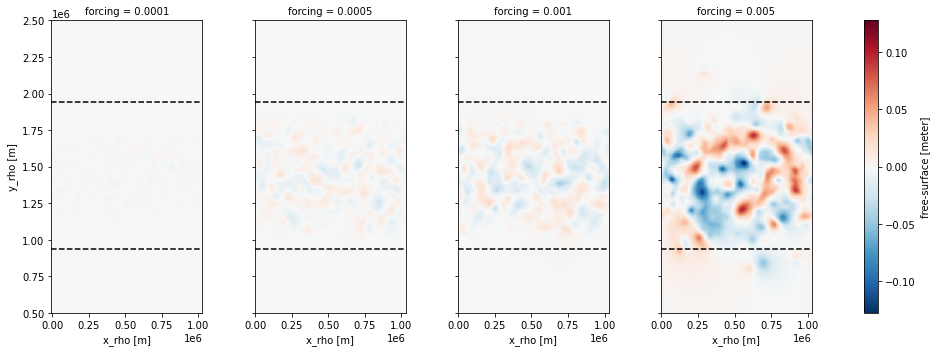

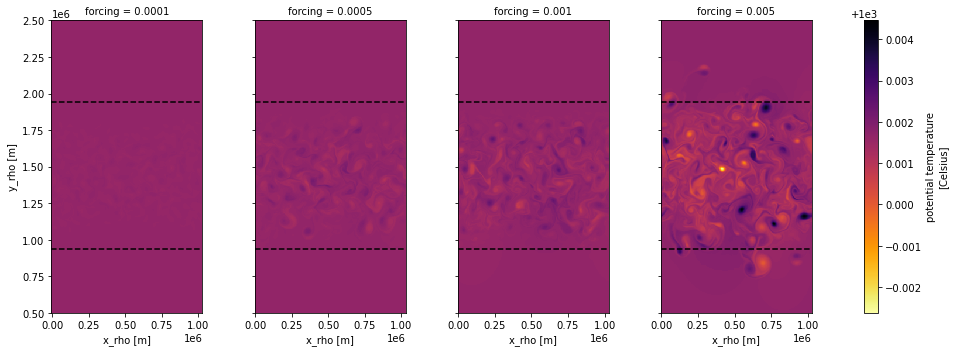

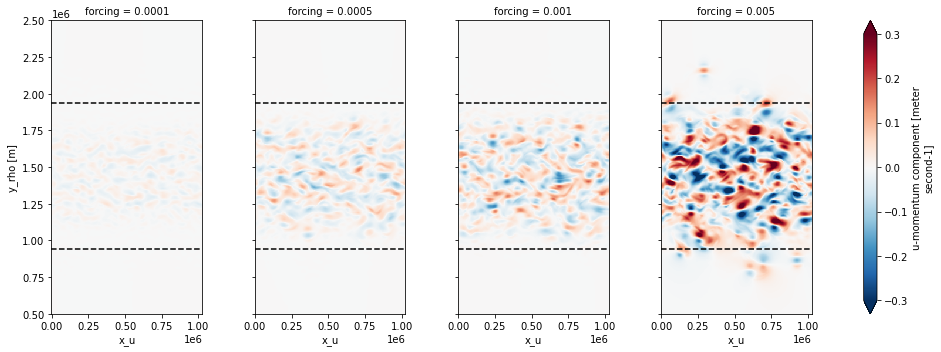

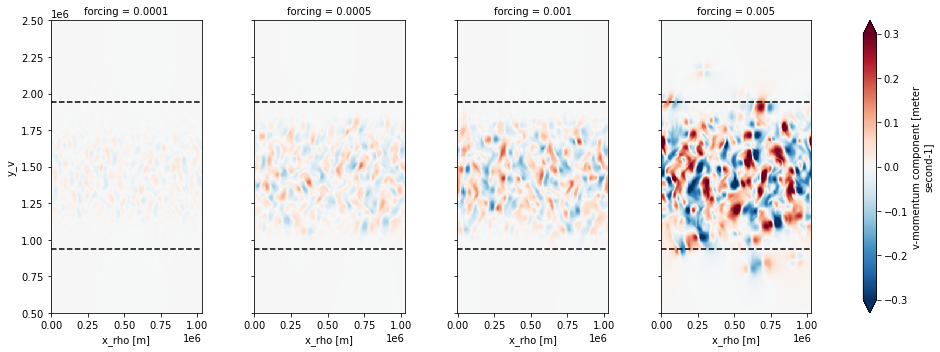

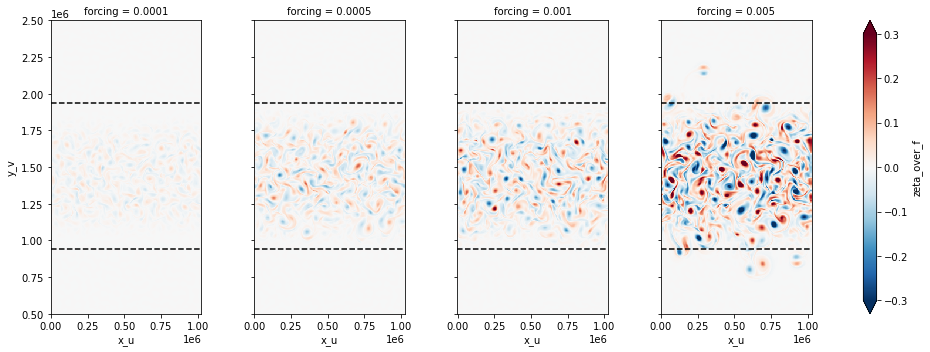

In [11]:
m = 0

for v in V:
    hdl = ds[v].sel(mode=m).plot(**hmap_kwargs, **vlims[v]) 
    #[ax.set_aspect('equal') for ax in hdl.axes.flatten()]
    for r, ax in zip(R[m], hdl.axes.flatten()):
        plot_Fy(r.params_output, ax=ax)

### mode 1

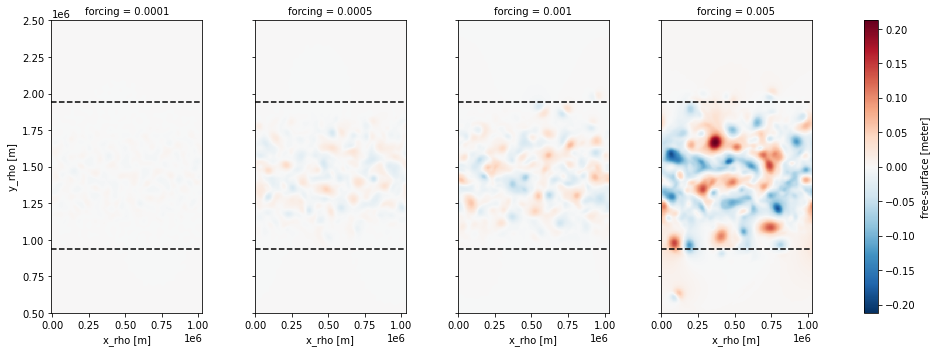

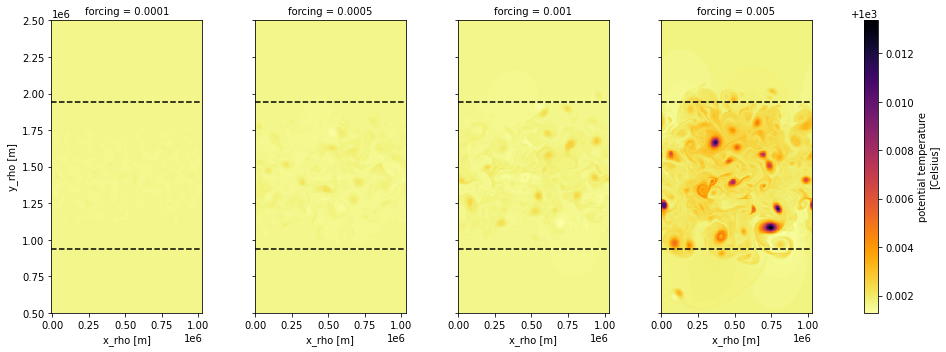

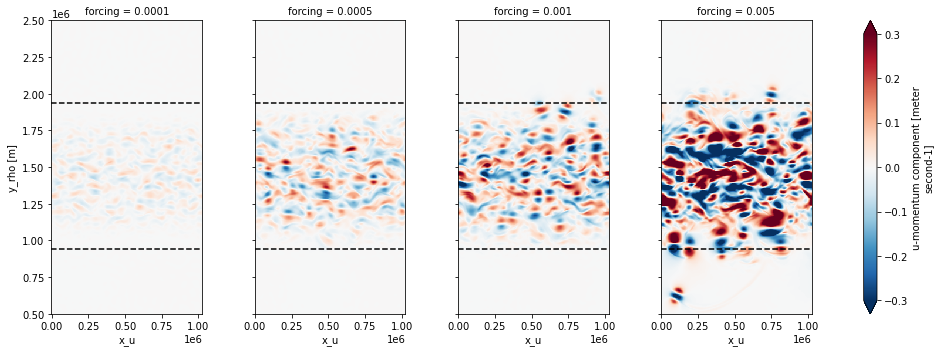

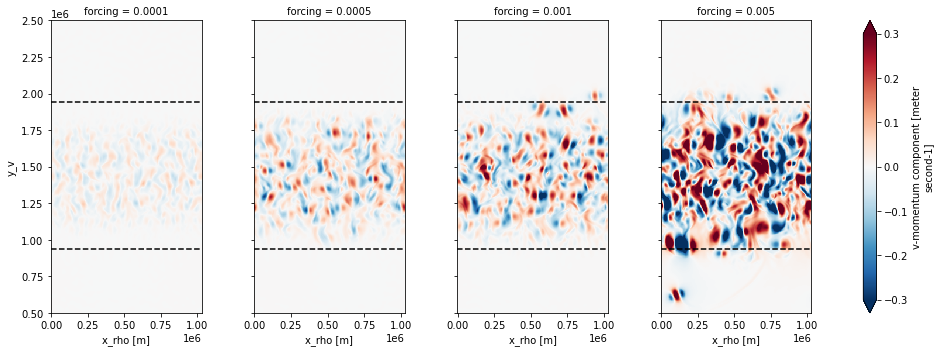

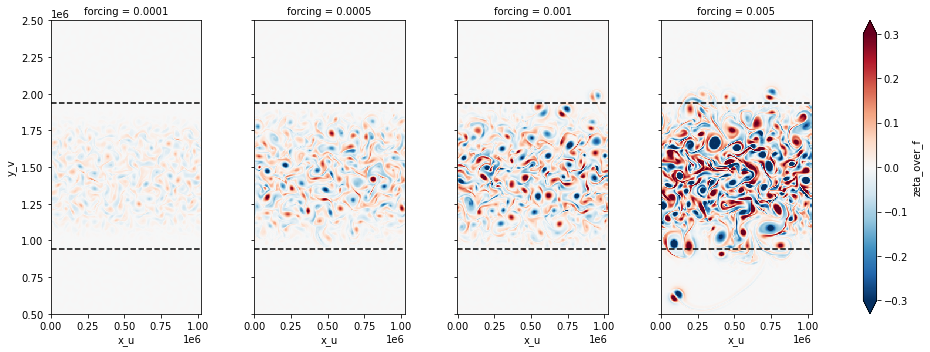

In [12]:
m = 1

for v in V:
    hdl = ds[v].sel(mode=m).plot(**hmap_kwargs, **vlims[v]) 
    #[ax.set_aspect('equal') for ax in hdl.axes.flatten()]
    for r, ax in zip(R[m], hdl.axes.flatten()):
        plot_Fy(r.params_output, ax=ax)

---

## time and zonally averaged statistics

In [13]:
ds = xr.concat([xr.concat([r.load_diagnostic('surface') for r in _R],
                         dim=pd.Series(forcing).rename('forcing'))
                for m, _R in R.items()],
               dim=pd.Series(M).rename('mode')
              ).persist()

# normalize enstrophy
ds['enstrophy_over_f'] = ds['enstrophy']/f_zeta.isel(x_u=0)**2

### mode 0

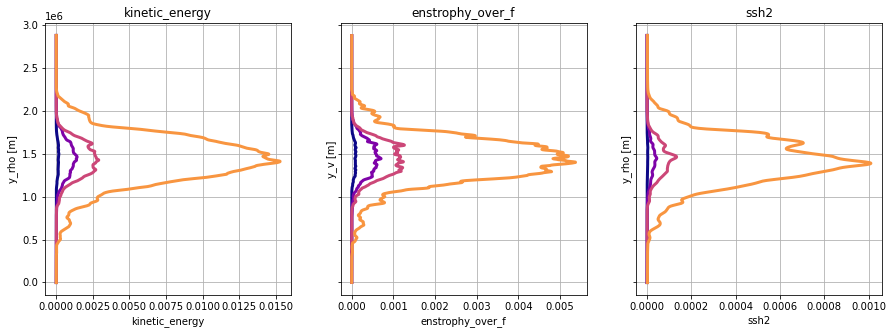

In [16]:
V = ['kinetic_energy', 'enstrophy_over_f', 'ssh2']

m=0

fig, axs = plt.subplots(1, len(V), figsize=(15, 5), sharey=True)
for v, ax in zip(V, axs):
    ydim = next((x for x in ds[v].dims if x[0]=='y'), None)
    for f, c in zip(forcing, colors[m]):
        ds[v].sel(mode=m).sel(forcing=f).plot(ax=ax, y=ydim, c=c, label='f={}'.format(f), lw=3)
    ax.grid()
    ax.set_title(v)

### mode 1

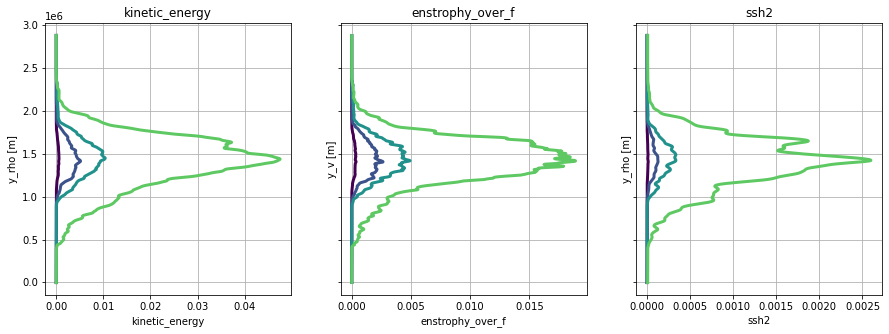

In [18]:
m=1

fig, axs = plt.subplots(1, len(V), figsize=(15, 5), sharey=True)
for v, ax in zip(V, axs):
    ydim = next((x for x in ds[v].dims if x[0]=='y'), None)
    for f, c in zip(forcing, colors[m]):
        ds[v].sel(mode=m).sel(forcing=f).plot(ax=ax, y=ydim, c=c, label='f={}'.format(f), lw=3)
    ax.grid()
    ax.set_title(v)

---

## movies

In [ ]:
def atom(ax, da, ax_kwargs, test=None, **plt_kwargs):
    #
    xc = next((x for x in da.dims if x[0]=='x'), False)
    yc = next((x for x in da.dims if x[0]=='y'), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    d = int(da.time)
    title = da.name+' day = %d'%(d)
    #h = (_da.time-d)*24
    #title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da.plot(x='x',y='y', ax=ax, **plt_kwargs)
    plot_Fy(pout, ax=ax, scale=1e-3)
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)

In [ ]:
r = R[0][0]

u, v = r['surf']['u'], r['surf']['v']

zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))
f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
da = (zeta/f_zeta).rename('zeta').isel(time=slice(0,None,1))
plt_kw = {'vmin': -.2, 'vmax': .2, 'cmap': 'RdGy_r', 
          'extend':'both'}
ax_kw = {'ylim': (900, 2000)}
cplt.movie_figure(atom, da, i=50, test=True, figsize=(8,8), 
             ax_kwargs=ax_kw, **plt_kw)

In [ ]:
i=0
for m in R:
    for r in R[m]:

    u, v = r['surf']['u'], r['surf']['v']
    zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))
    f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
    da = (zeta/f_zeta).rename('zeta').isel(time=slice(0,None,1))

    cplt.movie_wrapper(atom, client, da,
                       figsize=(8,8),
                       ax_kwargs=ax_kw,
                       fig_dir=os.environ['SCRATCH']+'/figs{}/'.format(i)
                       **plt_kw)
    i+=1
# for some reason, breaks if on a local (1 node) cluster
# with typical matplotlib thread issue:
# https://github.com/pydata/xarray/issues/1889

---

In [14]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
